In [1]:
# import system libs
import os
import itertools
from PIL import Image

# import handling data tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep Learning Libs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import warnings
warnings.filterwarnings("ignore")

print("Model Loaded")

2024-04-23 04:37:45.005967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 04:37:45.006070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 04:37:45.302436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model Loaded


In [2]:
# Generate Data paths with labels (TRAIN)

train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
        
# Concatenate Data Paths with Labels into one Dataframe

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='labels')

train_df = pd.concat([FSeries, LSeries], axis=1)

In [3]:
# Generate Data paths with labels (TEST)

test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='labels')

ts_df = pd.concat([FSeries, LSeries], axis=1)

In [4]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [5]:
# crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [72]:
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from keras import regularizers,Model

# Load pre-trained ResNet50 model without the top classification layer
# Load pre-trained InceptionV3 model without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tune some layers of the pre-trained InceptionV3 model
for layer in base_model.layers[:249]:
    layer.trainable = False
for layer in base_model.layers[249:]:
    layer.trainable = True


# Compile the model
model.compile(Adamax(learning_rate= 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_474 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_20[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_474[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_470      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_475 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_470[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_475[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_471      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_476 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_471[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_476[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_472      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 54, 54,    │          0 │ activation_472[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_477 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_24… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_477[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_473      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_478 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_473[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_478[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_474      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,853,924 (87.18 MB)

 Trainable params: 12,166,020 (46.41 MB)

 Non-trainable params: 10,687,904 (40.77 MB)

In [73]:

epochs = 10   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
  3/357 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.3299 - loss: 1.8893 

W0000 00:00:1713853776.554010     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


356/357 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7084 - loss: 0.7880

W0000 00:00:1713853801.977397     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 56s 86ms/step - accuracy: 0.7088 - loss: 0.7869 - val_accuracy: 0.8183 - val_loss: 0.4910
Epoch 2/10
  1/357 ━━━━━━━━━━━━━━━━━━━━ 51s 146ms/step - accuracy: 0.7500 - loss: 0.6334

W0000 00:00:1713853807.271430     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8769 - loss: 0.3282 - val_accuracy: 0.8947 - val_loss: 0.2485
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9256 - loss: 0.2023 - val_accuracy: 0.8977 - val_loss: 0.2413
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.9454 - loss: 0.1557 - val_accuracy: 0.9313 - val_loss: 0.1867
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9590 - loss: 0.1198 - val_accuracy: 0.9435 - val_loss: 0.1563
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.9667 - loss: 0.0913 - val_accuracy: 0.9359 - val_loss: 0.1846
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.9709 - loss: 0.0756 - val_accuracy: 0.9389 - val_loss: 0.1991
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9706 - loss: 0.0762 - val_accuracy: 0.9313 - val_loss: 0.2123
Epoch 9/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9823 - loss: 0.0554 - val_accurac

In [74]:
import pickle

# Save the history object using pickle
with open('teacher_inceptionV3_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


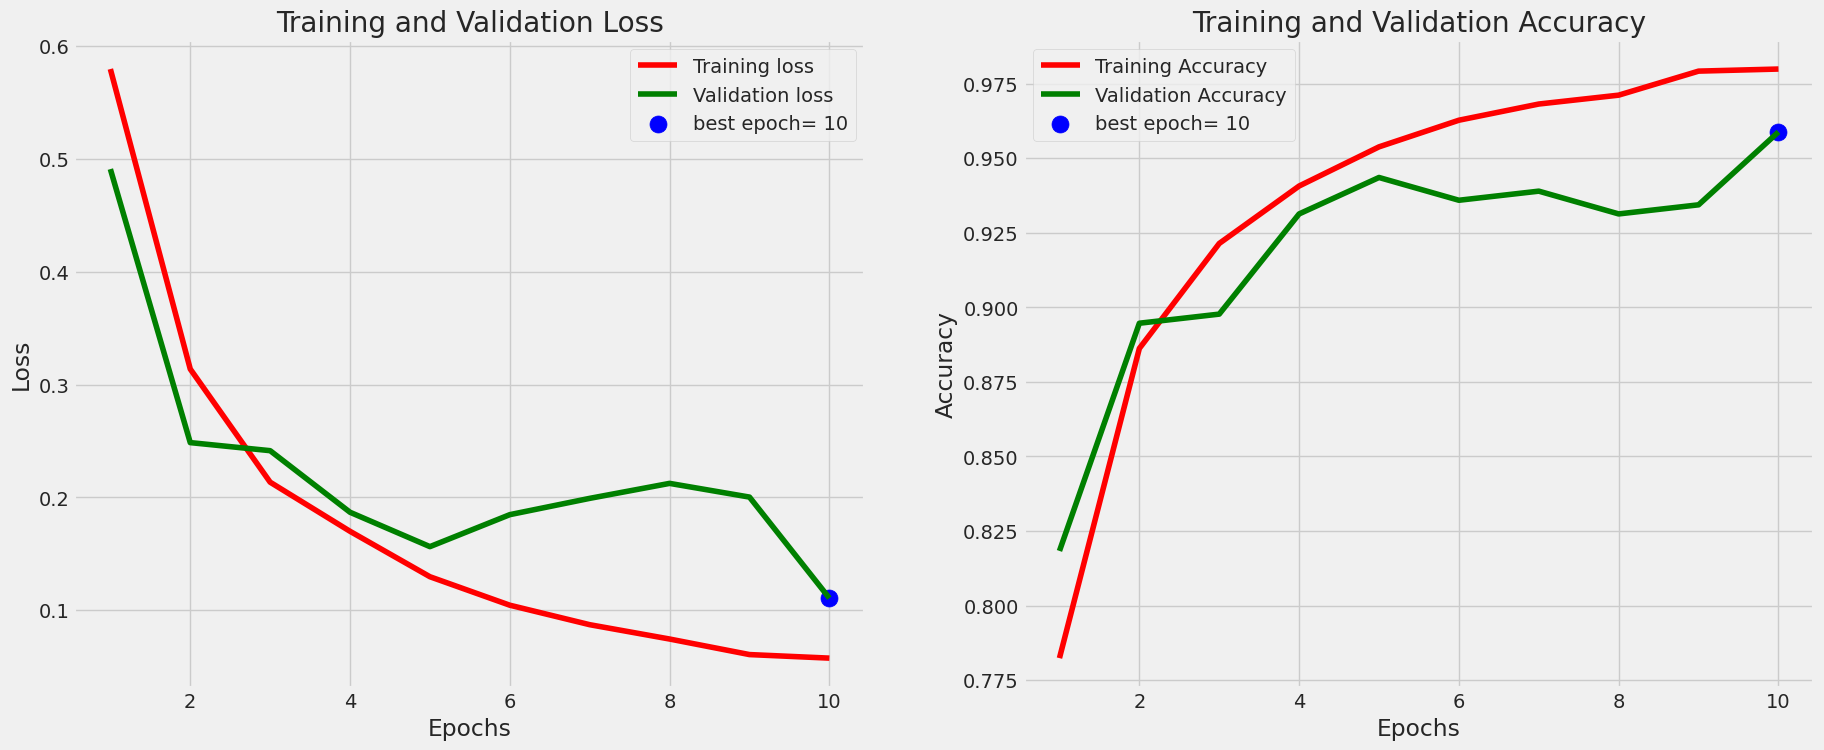

In [75]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [76]:
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9436 - loss: 0.1546
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9437 - loss: 0.1808
Validation Loss:  0.11057034879922867
Validation Accuracy:  0.9587786197662354
--------------------
Test Loss:  0.1392621099948883
Test Accuracy:  0.957317054271698


In [77]:
preds = model.predict(test_gen)  
y_pred = np.argmax(preds, axis=1) 

 4/41 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

W0000 00:00:1713854037.072658     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step


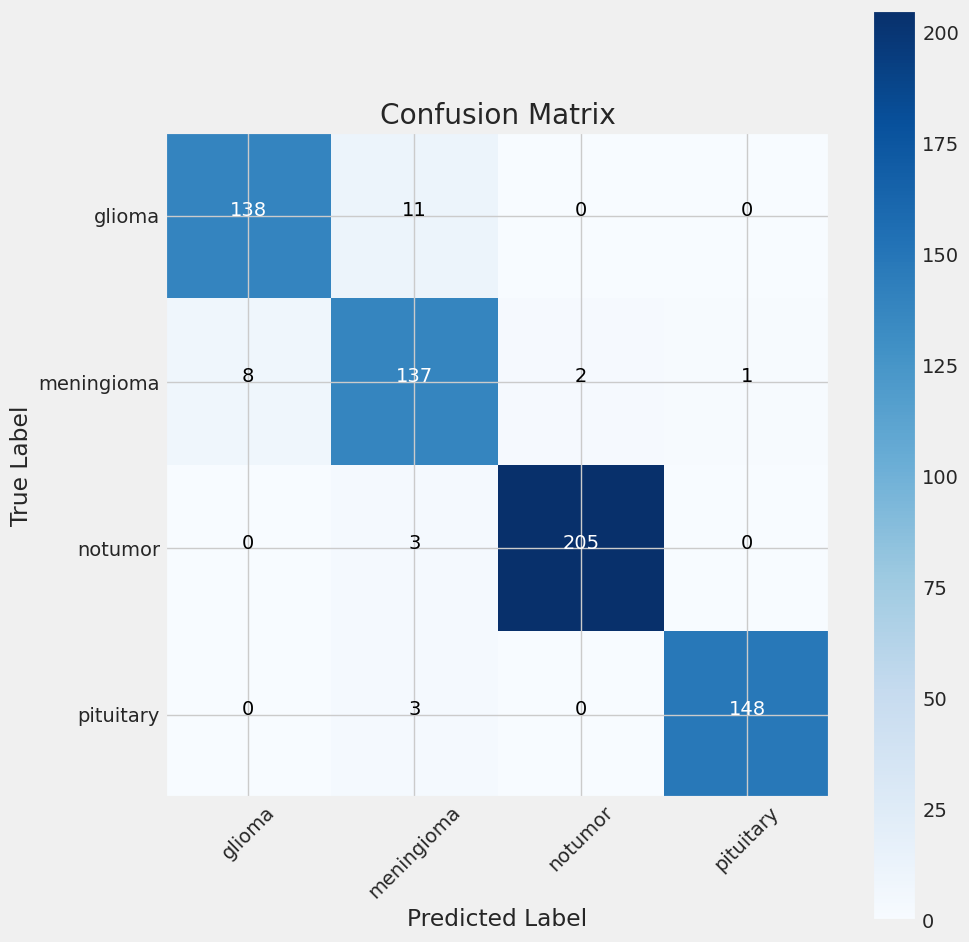

In [78]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [79]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.95      0.93      0.94       149
  meningioma       0.89      0.93      0.91       148
     notumor       0.99      0.99      0.99       208
   pituitary       0.99      0.98      0.99       151

    accuracy                           0.96       656
   macro avg       0.95      0.95      0.95       656
weighted avg       0.96      0.96      0.96       656



In [50]:
import os
os.remove('teacher_DenseNet121_history.pkl')

In [80]:
model.save('/kaggle/working/inceptionV3.h5')


In [81]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout


In [82]:
class Distiller(keras.Model):
    def __init__(self, student, teacher, activation):
        super().__init__()
        self.teacher = teacher
        self.student = student
        self.activation = activation

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=10,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=student_loss_fn)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                self.activation(teacher_predictions / self.temperature, axis=1),
                self.activation(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results

    def test_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)
        student_predictions = self.student(x, training=False)
        
        student_loss = self.student_loss_fn(y, student_predictions)
        distillation_loss = self.distillation_loss_fn(
            self.activation(teacher_predictions / self.temperature, axis=1),
            self.activation(student_predictions / self.temperature, axis=1),
        )
        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results
    
    def call(self, x):
        return self.student(x)

In [83]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

std_model_1 = Sequential()

std_model_1.add(Conv2D(filters=8, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
std_model_1.add(MaxPooling2D())

std_model_1.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
std_model_1.add(MaxPooling2D())

std_model_1.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
std_model_1.add(MaxPooling2D())
    
std_model_1.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
std_model_1.add(MaxPooling2D())
    
std_model_1.add(Flatten())
    
std_model_1.add(Dense(32,activation = "relu"))
std_model_1.add(Dense(16,activation = "relu"))
std_model_1.add(Dense(class_count, activation = "softmax"))

std_model_1.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

std_model_1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_568 (Conv2D)             │ (None, 224, 224, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_569 (Conv2D)             │ (None, 112, 112, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_570 (Conv2D)             │ (None, 56, 56, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_571 (Conv2D)             │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │       200,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,684 (819.08 KB)

 Trainable params: 209,684 (819.08 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
distiller = Distiller(std_model_1, model, tf.nn.softmax)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

In [85]:
history_distil = distiller.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
  3/357 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.3681 - distillation_loss: 0.0016 - loss: 1.8756 - student_loss: 18.7421

W0000 00:00:1713854088.411063     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713854088.413853     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6196 - distillation_loss: 5.0124e-04 - loss: 0.1008 - student_loss: 1.0038

W0000 00:00:1713854112.994530     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713854113.023810     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.6199 - distillation_loss: 5.0124e-04 - loss: 0.1013 - student_loss: 1.0038 - val_accuracy: 0.8489 - val_loss: 0.2500
Epoch 2/10
  1/357 ━━━━━━━━━━━━━━━━━━━━ 47s 134ms/step - accuracy: 0.8750 - distillation_loss: 2.2229e-04 - loss: 0.0359 - student_loss: 0.3575

W0000 00:00:1713854118.375061     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713854118.405745     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8727 - distillation_loss: 2.3097e-04 - loss: 0.0357 - student_loss: 0.3490 - val_accuracy: 0.8733 - val_loss: 0.2500
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9225 - distillation_loss: 1.4904e-04 - loss: 0.0226 - student_loss: 0.2187 - val_accuracy: 0.9206 - val_loss: 0.2500
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9552 - distillation_loss: 1.0432e-04 - loss: 0.0152 - student_loss: 0.1442 - val_accuracy: 0.8824 - val_loss: 0.2500
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9636 - distillation_loss: 7.8329e-05 - loss: 0.0118 - student_loss: 0.1103 - val_accuracy: 0.9542 - val_loss: 0.2500
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.9637 - distillation_loss: 8.0346e-05 - loss: 0.0119 - student_loss: 0.1116 - val_accuracy: 0.9237 - val_loss: 0.2500
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9849 - distillatio

In [86]:
import pickle

# Save the history object using pickle
with open('student_inceptionv3_history.pkl', 'wb') as file:
    pickle.dump(history_distil.history, file)


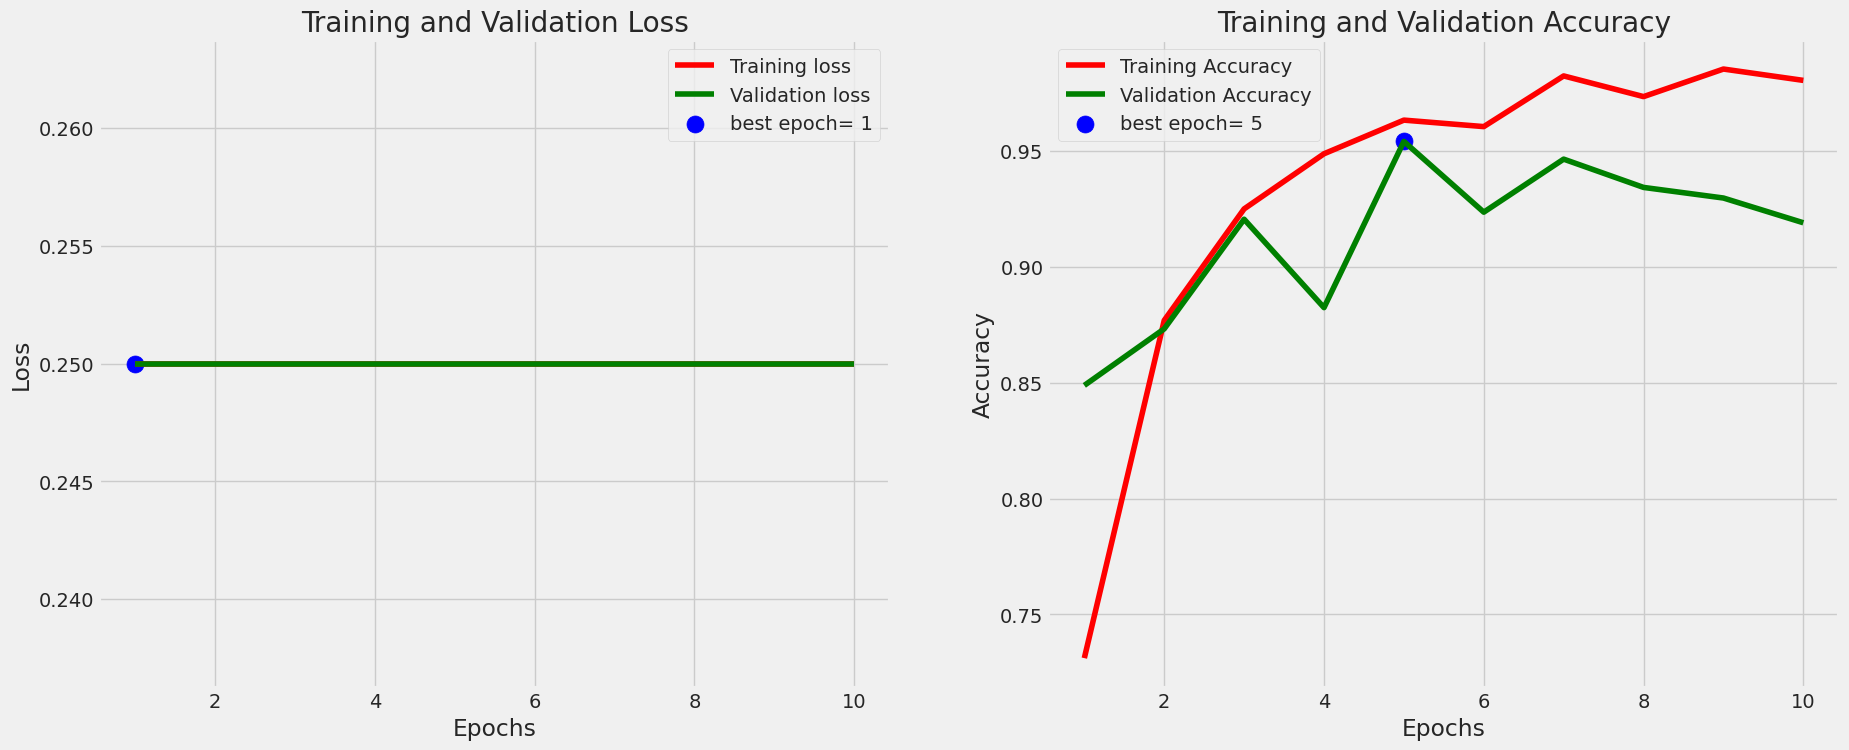

In [87]:
# Define needed variables
tr_acc = history_distil.history['accuracy']
tr_loss = history_distil.history['loss']
val_acc = history_distil.history['val_accuracy']
val_loss = history_distil.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [88]:
valid_score = std_model_1.evaluate(valid_gen, verbose= 1)
test_score = std_model_1.evaluate(test_gen, verbose= 1)

print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

 5/41 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9283 - loss: 0.1593 

W0000 00:00:1713854315.912543     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9126 - loss: 0.2369
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 1.0000 - loss: 0.0174

W0000 00:00:1713854318.218111     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9542 - loss: 0.3037
Validation Loss:  0.23006220161914825
Validation Accuracy:  0.9190839529037476
--------------------
Test Loss:  0.3344736397266388
Test Accuracy:  0.9481707215309143


In [89]:
preds = std_model_1.predict(test_gen)  
y_pred = np.argmax(preds, axis=1) 

 5/41 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step 

W0000 00:00:1713854334.792999     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


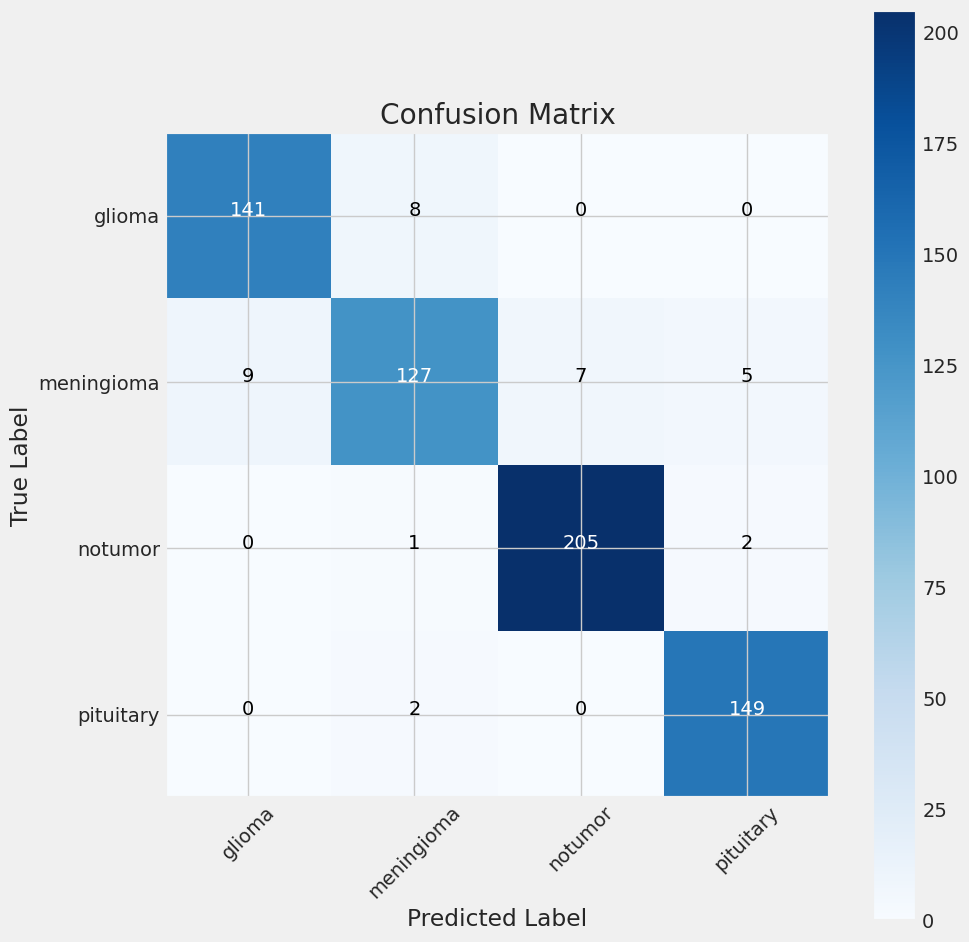

In [90]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [91]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.94      0.95      0.94       149
  meningioma       0.92      0.86      0.89       148
     notumor       0.97      0.99      0.98       208
   pituitary       0.96      0.99      0.97       151

    accuracy                           0.95       656
   macro avg       0.95      0.94      0.94       656
weighted avg       0.95      0.95      0.95       656



In [92]:
std_model_1.save('/kaggle/working/std_distil_inceptionv3.h5')


In [ ]:
model.save('inceptionV3.h5')